In [31]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

from plotting import plot_prettier, plot_histogram

%load_ext autoreload
%autoreload 2

plot_prettier(fontsize=12)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## <font color='darkblue'>Distribution function reconstruction</font>

Reconstructing the form of the underlying density distribution function from samples from this distribution is a frequently encountered problem in data analysis. Surprisingly, it is also one of the least considered and developed area of data analysis techniques.  

Most frequently function reconstruction is carried out with a histogram -- the binned frequency distribution of data samples. 
Indeed, histogramming data is one of the most commonly encountered data processing tasks in research and presentation of research results.

Histograms are also a specific case of a more general class of distribution function reconstruction methods called *Kernel Density Estimation* (KDE; e.g., [Silverman 1998](https://www.taylorfrancis.com/books/mono/10.1201/9781315140919/density-estimation-statistics-data-analysis-bernard-silverman), or a short summary of the book [here](https://ned.ipac.caltech.edu/level5/March02/Silverman/paper.pdf)). 

Histogram and all of the KDE variants face the same set of questions, however: 

* What are the optimal bin sizes (in histogram) or kernel sizes (in KDE)?

* What is the uncertainty of the reconstructed function?

Generally, the first question is answered by trial and error with bin size chose so that histogram looks good to the person constructing it (hereafter, the "looks good method"). 

The second question is usually not even asked or uncertainty is estimated using Poisson uncertainty from the counts in individual bins (the approach that is not easily transferrable for a general KDE method). 

### <font color='darkblue'>Is "looks good" approach to choosing bin size always good enough?</font>

For quick everyday explorations and plots the "looks good" approach is fine. However, when we suspect interesting features in the data or prepare a plot for a presentation or publication we may need to be more careful and discerning about whether histogram is dominated by noise and use a more objective method. 

The objective method can be understood broadly to mean that the same binning will be produced for the same data when different people apply the method. 

What objective methods are available?

### <font color='darkblue'>Binning methods in [<tt>numpy.histogram</tt>](https://numpy.org/doc/stable/reference/generated/numpy.histogram.html)</font>

In <tt>NumPy</tt> the [<tt>numpy.histogram</tt>](https://numpy.org/doc/stable/reference/generated/numpy.histogram.html) function allows specifying the method to be used in choosing the number of bins in producing histogram via the <tt>bins</tt> argument. 

These methods are listed in the description of [<tt>numpy.histogram_bin_edges</tt>](https://numpy.org/doc/stable/reference/generated/numpy.histogram_bin_edges.html#numpy.histogram_bin_edges): 
 <tt>'auto', 'sturges', 'scott', 'fd', 'doane',  'rice', 'sqrt'.</tt> The <tt>'auto'</tt> is the maximum number of bins 
 that is produced by the 'sturges' and 'fd' methods (supposed to be the most versatile, but shares the same issues as the methods it is based on). What about the other options? The methods they refer to are often called *heuristic methods* because they are based on some strong heuristic assumptions about underlying distribution or use heuristic fixes to issues in the underlying methods. For example, Doane method applies a heuristic hack to fix the issues of the Sturges method. 
 
For an array of sample values $\mathbf{x}$ of size $N$ the number of histogram bins of equal width is related to the bin width as: 

$$N_{\rm b} = \left\lceil \frac{{\rm max}(\mathbf{x}) - {\rm min}(\mathbf{x})}{h}\right\rceil.$$

| rule name | numpy.histogram bins option |  Number of bins or bin width | Comments |
|------|------|------------------------|-----------|
| Sturges | <tt>'sturges'</tt> | $$N_{b, \rm Sturges}=1+\lceil\log_2 N\rceil$$ | assumes Gaussian distribution and heuristic (generally incorrect) about number of bins, only gives reasonable result for $N<200$ |
| Doane | <tt>'doane'</tt> | $$N_{b, \rm Doane}=1+\lceil\log_2 N+\log_2\left(1+s/\sigma_s\right)\rceil$$ | where $s$ is the skewness of the sample and $$\sigma_s=\sqrt{6(n-2)/[(n+1)(n+3)]}.$$ This method aims to fix the issues of the Sturges method. |
| Scott | <tt>'scott'</tt> | $$h_{\rm Scott} = \frac{3.5\sigma}{N^{1/3}}$$ | $\sigma$ is rms of the sample distribution, assumes Gaussian distribution | 
| Freedman-Diaconis | <tt>'fd'</tt> | $$h_{\rm FD}=2\,\frac{{\rm IQR(\mathbf{x})}}{N^{1/3}},$$ | replaces $3.5\sigma$ of the Scott rule with $2\,{\rm IQR(\mathbf{x})}$ to avoid sensitivity of $\sigma$ to outliers | 
| Rice | <tt>'rice'</tt> | $$N_{b, \rm Rice}=\lceil 2N^{1/3}\rceil$$ | tries to remedy slow increase of the number of bins of the Sturges rule with increasing sample size. |
| Square root | <tt>'sqrt'</tt>| $$N_{b, \rm sqrt}=\lceil \sqrt{N}\rceil$$ | tries to remedy slow increase of the number of bins of the Sturges 

These methods will produce reproducible result, but are any of them optimal in general? The answer is no. They only work reasonably well for single peaked Gaussian-like distributions. 

Can we do better?

## <font color='darkblue'>Bayesian methods for choosing bin sizes</font>

### The Shimazaki-Shinomoto method

Developed by <a href="http://www.neuralengine.org/res/pdf/shimazaki_neco07.pdf">Shimazaki & Shinomoto (2007)</a> to bin discrete counts of some signal as a function of time, assuming that noise in accumulated counts is described by the <a href="https://en.wikipedia.org/wiki/Poisson_distribution">Poisson distribution</a>. Can be applied to general binning problem of samples in a vector $\mathbf{x}$, if this assumption is reasonable.  

The method defines  a grid of bin numbers $\{N\}=N_{\rm min}\ldots, N_{\rm max}$, which encompass all expected reasonable numbers for bins, and for each number of bins $N$ and corresponding bin width $h=(x_{\rm max}-x_{\rm min})/N$ computes the following ***cost function***:

$$C(h) = \frac{2\bar{n}-v}{h^2}, $$

where $\bar{n}$ and $v$ are the mean and the biased variance of the sample counts in the bins: 

$$\bar{n}=\frac{1}{N}\,\sum\limits_{i=0}^{N-1}n_i,$$
$$ v=\frac{1}{N}\,\sum\limits_{i=0}^{N-1}(n_i-\bar{n})^2,$$

*The number of bins that minimizes $C(h)$ is the optimal number.*

One of the key characteristics of the Poisson distribution is that its mean $\mu$ is equal to its variance $\sigma^2=\mu$. Or, in other words, the standard deviation of the Poisson distribution is $\sigma = \sqrt{\mu}$. 

Thus, for if sample counts in bins have the Poisson distribution, we should have $2\bar{n}-v\approx \bar{n}\approx v=\sigma^2$. Thus the minimized cost function is 

$$C(h) = \frac{2\bar{n}-v}{h^2}\approx \left(\frac{\sigma}{h}\right)^2$$

As the bin width decreases with increasing number of bins, the number of samples per bin decreases and their scatter $\sigma$ increases. Thus, minimizing $C(h)$ finds an *optimal* bin width that is a tradeoff between desire to have small bin size, while keeping the "Poisson noise" due to limited number of bins in check. 

Shimazaki-Shinomoto method can be used for bootstrap resamplings of samples and with slightly different $x_{\rm min}$ and $x_{\rm max}$ choices so that results can be averaged and a more robust prediction obtained. This method is implemented in the function below. 

In [32]:
def shimazaki_shinomoto_rule(x, nbmin=4, nbmax=500):
    """
    Compute the number of bins for samples in an array x using the 
    Shimazaki and Shinomoto (2007) method
    
    Parameters
    ----------
    
    x: array-like, ndim=1, data samples
    nbmin, nbmax: int, minimum and maximum number of bins to examine
    
    Returns
    -------
    
    nb_best: int, the optimal number of bins according to the method
    h_best: float, bin size corresponding to nb_best
    """
    
    x_max = np.max(x)
    x_min = np.min(x)
    nbins = np.arange(nbmin, nbmax) # vector of bin numbers
    hb = (x_max - x_min) / nbins    # bin size vector
    C = np.empty_like(hb)

    # computation of the cost function
    for i, nb in enumerate(nbins): 
        ni = np.histogram(x, bins=nb)[0]
        nbar = np.mean(ni) # mean of counts in bins
        v = np.var(ni)  # biased variance estimate of counts in bins
        C[i] = (2. * nbar - v) / (hb[i]**2) # the cost function 

    # optimal bin size: find index of the smallest C
    imin = np.argmin(C)
    nb_best, h_best  = nbins[imin], hb[imin]
    
    return nb_best, h_best     

### The Knuth method

An approach for estimating the number of bins based on the rigorous Bayesian statistics was proposed by physicist <a href="http://knuthlab.rit.albany.edu/">Kevin Knuth</a> (<a href="http://adsabs.harvard.edu/abs/2006physics...5197K">Knuth 2006</a>) where details can be found. 

As a brief summary, the method considers histogram as a piecewise constant model with a given number of bins of the data and computes the likelihood pdf for such model given the samples and a given number of bins with a simple, non-informative prior to compute the posterior distribution for the number of bins using the Bayes theorem.

This method is implemented in [<tt>astropy.visualization.hist</tt>](https://docs.astropy.org/en/stable/_modules/astropy/visualization/hist.html) function (see [here](https://docs.astropy.org/en/stable/visualization/histogram.html) for examples of use). 

### Bayesian blocks method

Objective methods for producing histograms with variable bin size are also used, in particular the <a href="http://jakevdp.github.io/blog/2012/09/12/dynamic-programming-in-python/">***Bayesian blocks*** method</a> proposed by astronomer Jeff Scargle and collaborators in 2013 (<a href="https://ui.adsabs.harvard.edu/abs/2013ApJ...764..167S/abstract">Scargle et al. 2013</a>) for binning counts in astronomical time series. In such series there are lull periods when nothing happens and large bin sizes can be used and sudden bursts of flux, as during gamma-ray bursts, when bin sizes need to be adaptively decreased to capture structure of the signal.   

It uses approach similar to that of the Knuth method, but relaxes assumption of the constant bin size. 


This method is implemented in [<tt>astropy.visualization.hist</tt>](https://docs.astropy.org/en/stable/_modules/astropy/visualization/hist.html) function (see [here](https://docs.astropy.org/en/stable/visualization/histogram.html) for examples of use). 

Are these methods optimal? It is not clear if they are used in isolation. 

In the personal experience of the author, it is also rather difficult to explain the logic underlying these methods, especially at undergraduate level. To overcome this issue, a more intuitive method based on the Kolmogorov-Smirnov (KS) statistic and test was developed. 

The method is briefly described below and is compared to the Knuth and Bayesian Blocks methods. 

## <font color='darkblue'>KS based objective binning method</font>

The method is based on the "one-sample Kolmogorov" test briefly reviewed below. 

### KS "goodness-of-fit test"

As a refresher, the KS goodness-of-fit test uses a cumulative distribution of $n$ sample values, $x_i$, drawn from an unknown distribution and compares it to a given known pdf function, $p(x)$, with the cdf $P(x)$. 

The cumulative distribution for a sample is computed as

$$F_n(x) = \frac{1}{n}\,\sum\limits_{i=0}^{n-1} I(x_i\leq x),$$

where $I(x_i\leq x)=1$ if $x_i\leq x$ and zero otherwise. 

The KS statistic is 

$$D_{\rm KS1} = \sqrt{n}\, \max\limits_n \vert F_n(x)-P(x)\vert$$

This statistic is then used to compute the probability that the sample was drawn from $p(x)$ using the CDF of the Kolmogorov pdf. 

The Kolmogorov pdf for $x=D_{\rm KS1}$ is defined as

$$k(x) = \max\limits_{x\in[0,1]}\vert b(x)\vert,$$

where $b(x)$ is called [the Brownian bridge distribution](https://en.wikipedia.org/wiki/Brownian_bridge), given by the cdf:

$$K(D_{\rm KS}\leq x) = 1 - 2\,\sum\limits_{k=1}^\infty (-1)^{k-1} e^{-2k^2 x^2}$$

This sum can be computed numerically using [<tt>scipy.special.kolmogorov</tt>](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.kolmogorov.html)

Formal derivation of these equations can be found in these [MIT Lecture Notes](https://ocw.mit.edu/courses/18-443-statistics-for-applications-fall-2006/0c5a824a932b841205b7bb4d27229abc_lecture14.pdf).

### KS-based method to find optimal number of equal-sized bins

We can consider a histogram as a stepwise representation of the reconstructed function. Representation of a function by a constant in a given interval makes sense if the KS probability that samples are drawn from the uniform pdf over this interval is high. The basic idea for finding an optimal number of equal sized bins using KS test is based on this and is quite simple. 

Assume we are to find the optimal number of equal-size bins in the interval $[x_{\rm min}, x_{\rm max}]$. We try different number of bins from $N_{\rm b,min}$ to $N_{\rm b,max}$. For each number of bins, we compute KS probability for samples in each bin to be consistent with a uniform pdf in that bin. If we assume that samples in each of the bin are correlated, the optimal number of bins maximizes the total probability:

$$ P_{\rm KS} = \prod\limits_{i=1,N_i\ne 0}^{N_{\rm b,opt}} P_{i,\rm KS}.$$

Or, to avoid underflow when probability is low and/or the number of bins is large:

$$\ln P_{\rm KS} = \sum \limits_{i=1,N_i\ne 0}^{N_{\rm b,opt}} \ln P_{i,\rm KS}.$$

Note that we only account for the bins containing samples and ignore empty bins. This method is implemented in function <tt>ks_optimal_nbin</tt> in file <tt>ksbins.py</tt>. See examples of its use below.

### Prior for the number of bins

If we just use the probability distribution function defined above to derive the number of bins, this is equivalent to assuming a uniform prior on the number of bins within the range $[N_{\rm b,min},N_{\rm b,max}]$ in the Bayesian approach. 

In general we can multiply the above probability distribution function by a prior $P_{\rm pr}(N_{\rm b})$ chosen by some considerations. One of the choices is a "geometric prior" is used (see Section 3.2 of [Scargle et al. 2013](https://ui.adsabs.harvard.edu/abs/2013ApJ...764..167S/abstract) and discussion and references therein):

$$P_{\rm pr}(N_{\rm b})=\frac{1-\gamma}{1-\gamma^{N_s+1}}\, \gamma^N_{\rm b},$$

where $N_s$ is the total number of samples with which we construct a histogram.

For $\gamma<1$ the prior increases towards smaller $N_{\rm b}$, i.e. favors smaller number of bins, while for $\gamma>1$ it will favor larger number of bins. As $\gamma\rightarrow 1$ it tends to a uniform prior. 

This prior is implemented in the function <tt>nbin_geom_prior</tt> in <tt>ksbins</tt> and there are examples, of how it can be used below. 

Most examples below use uniform prior, however, to show how the KS-based method works in this case. 

### KS-based adaptive binning method 

Adaptive version of the KS-based binning is also fairly easy to develop (there is more than way to do this! Try to think of your own method.). In the implementation of <tt>ks_adaptive_bins</tt> in <tt>ksbins</tt> the following approach is adopted. 

* Estimate the optimal number of equal-size bins, $N_{\rm b,opt}$, described above for the desired interval $[x_{\rm min}, x_{\rm max}]$. Set the current number of bins $N_{\rm b}=N_{\rm b,opt}$


* Then iterate through the following steps until the number of bins stops changing:

  For each non-empty bin $i$ spanning $[x_i,x_{i+1}]$ of the $N_{\rm b,opt}$ bins that contains more than $N_{\rm min}$ samples,   find the median value of the samples in the bin, $x_{\rm med,i}$. 
  
  Compute KS probability $P_{L,\rm KS}$ for the bin samples $x_i\leq x< x_{\rm med,i}$ to be consistent with the constant pdf.
  
  Compute KS probability $P_{R,\rm KS}$ for the bin samples $x_{\rm med,i}\leq x\lt<x_{i+1}$ to be consistent with the constant pdf.
  
  Create two new bins spanning $[x_i, x_{i,\rm med}]$ and $[x_{i,\rm med},x_{i+1}]$ if $P_{L,\rm KS} P_{R,\rm KS} P_{\rm pr}(N_{\rm b}+1)>P_{i,\rm KS}P_{\rm pr}(N_{\rm b})$ AND the number of samples in both new bins is $>N_{\rm min}$, where  $P_{i,\rm KS}$ is the KS probability for he samples in the bin $i$ to be drawn from a uniform pdf. 


* The last part is a pass over all bins. Bins with fewer than $N_{\rm min}$ particles are joined into a single bin. 
Successive empty bins are joined into a single bin. 

## <font color='darkblue'>Examples of using objective binning method based on the Kolmogorov-Smirnov (KS) statistic</font>


### An example of use

In [33]:
nr = 3000
x = np.hstack((np.random.normal(scale=0.1, size=nr), np.random.normal(scale=1, size=nr)))

First constant size KS-based binning method

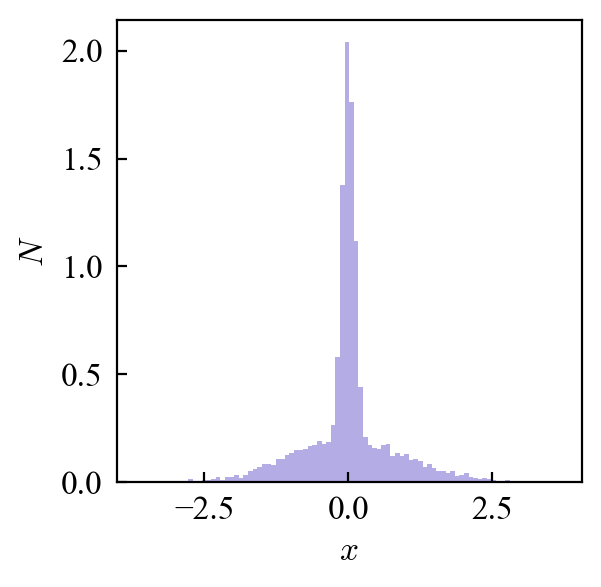

In [34]:
from ksbins import ks_optimal_nbin

# optimal number of equal-size bins using KS-based method
nbins, edges, pks = ks_optimal_nbin(x)

plot_histogram(x, bins=edges, xlabel='$x$', ylabel='$N$', density=True)

Bin only within specified interval.

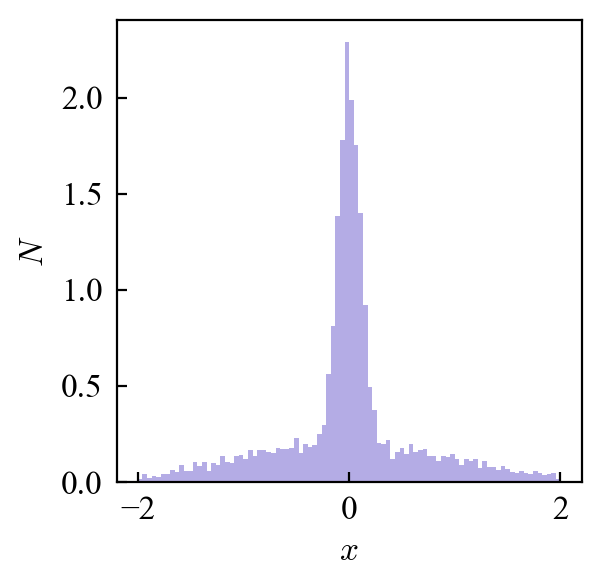

In [35]:
# optimal number of equal-size bins using KS-based method
nbins, edges, pks = ks_optimal_nbin(x, x_interval=[-2.,2.]) 

plot_histogram(x, bins=edges, xlabel='$x$', ylabel='$N$', density=True)

Adaptive binning allows to reconstruct the narrow central peak more finely. 

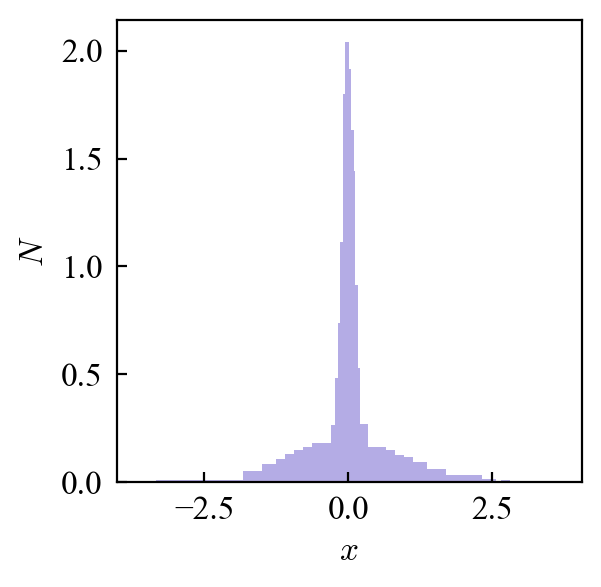

In [36]:
from ksbins import ks_adaptive_bins

ksnabins, aedges = ks_adaptive_bins(x, nminb=100)

plot_histogram(x, bins=aedges, xlabel='$x$', ylabel='$N$', density=True)

Example of how to use geometric prior instead of the default uniform one. Try to experiment with the value of <tt>gamma</tt> and see how it affects results. 

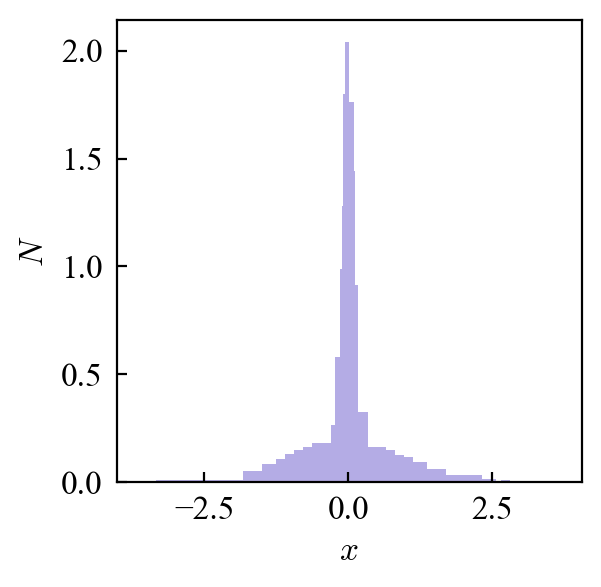

In [37]:
from ksbins import nbin_geom_prior

ksnabins, aedges = ks_adaptive_bins(x, nminb=100, prior_func=nbin_geom_prior, prior_kwargs={'gamma': 0.9})

plot_histogram(x, bins=aedges, xlabel='$x$', ylabel='$N$', density=True)

Compare to the Bayesian blocks and Knuth binning methods from <tt>AstroPy</tt>.

In [38]:
from astropy.visualization import hist
from ksbins import nbin_uniform_prior

def compare_binning_methods(x, func=None, args=[], nminb=10, 
                            prior_func=nbin_uniform_prior, prior_kwargs={},
                            xlims=None, ylims=None):
    
    ksnabins, ksabins = ks_adaptive_bins(x, nminb=nminb, prior_func=prior_func, prior_kwargs=prior_kwargs)

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    if func is not None:
        xg = np.linspace(x.min(), x.max(), 1000)
        pxg = func(xg, *args)

    fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
    for i, bins in enumerate([ksabins, 'blocks', 'knuth']):
        if func is not None: 
            ax[i].plot(xg, pxg, '-', color='orangered', lw=0.5, alpha=1., label='cauchy pdf')
        #if bins == 'knuth':
        #    dx, bins = knuth_bin_width(x, return_bins=True)
        hist(x, bins=bins, ax=ax[i], histtype='stepfilled',
                color='mediumslateblue', alpha=0.7, density=True)
        ax[i].set_xlabel('$x$')
        if i == 0: ax[i].set_ylabel('$p(x)$')
        ax[i].grid(ls='dotted')
        if xlims is not None:
            ax[i].set_xlim(xlims)
        if ylims is not None:
            ax[i].set_ylim(ylims)
        if i: ax[i].set_title(bins)
        else: ax[i].set_title('KS-based')


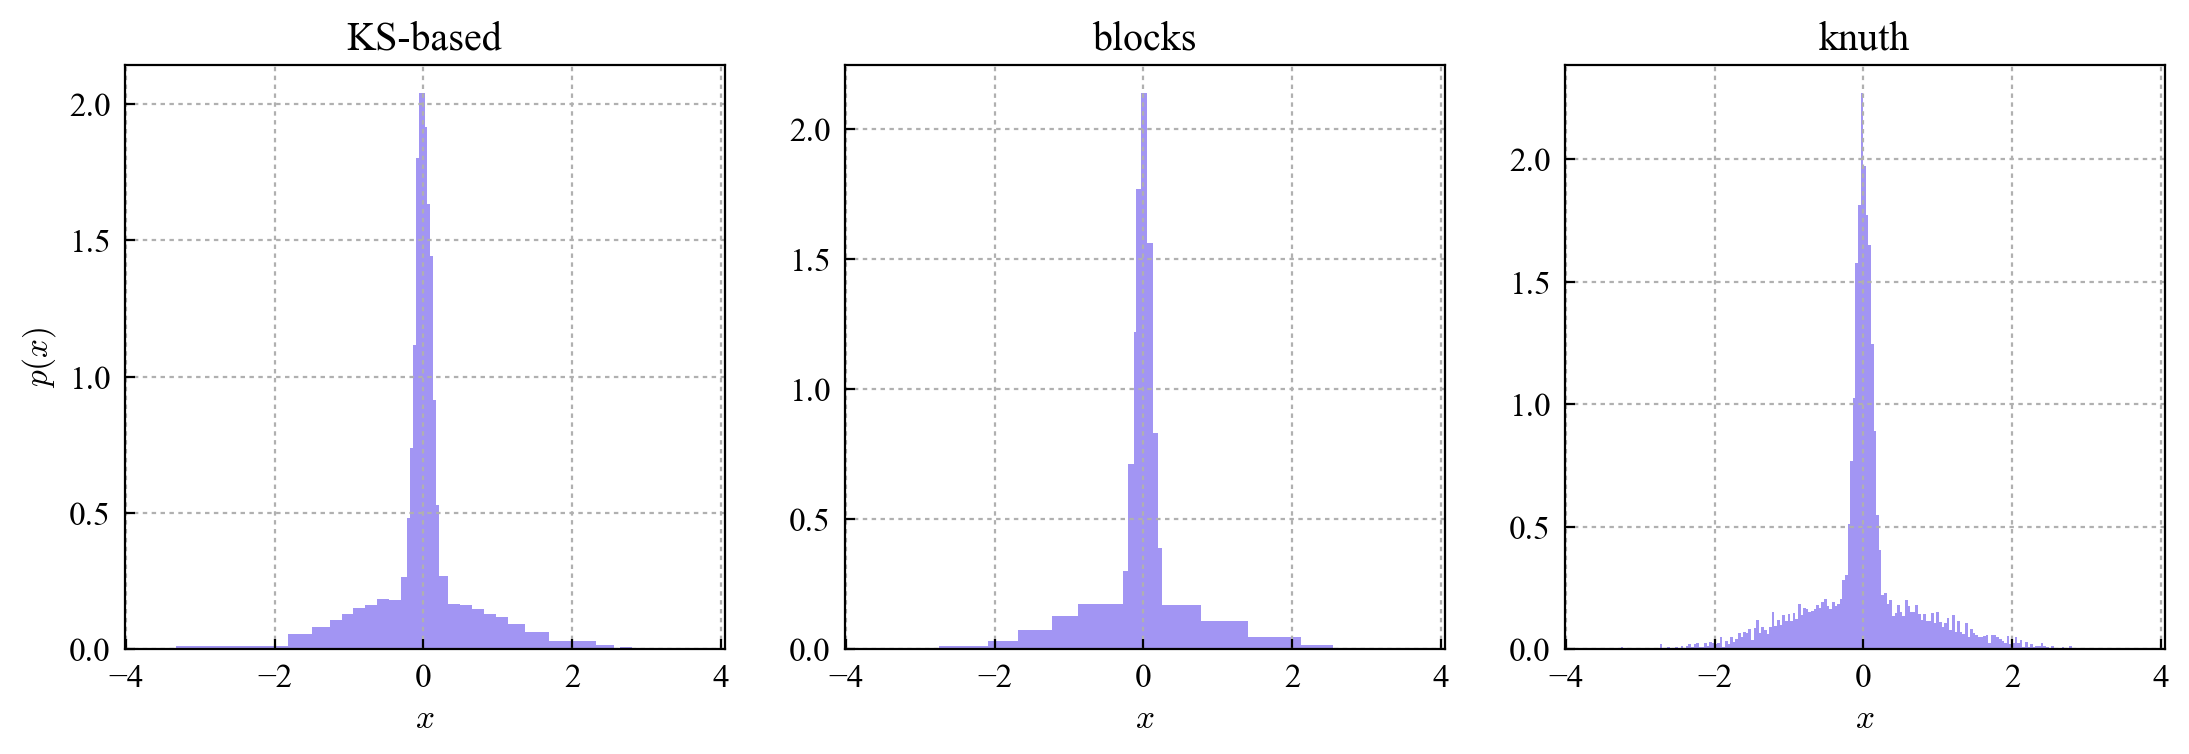

In [39]:
compare_binning_methods(x, nminb=100)

###  Test on a "blocky" distribution with a gap

Knuth method fails here due to a large gap. Bayesian blocks works perfectly. KS-based method also produces reasonable histogram. The noise in the second range can be suppressed by using large minimum number of samples per bin <tt>nminb</tt> parameter.

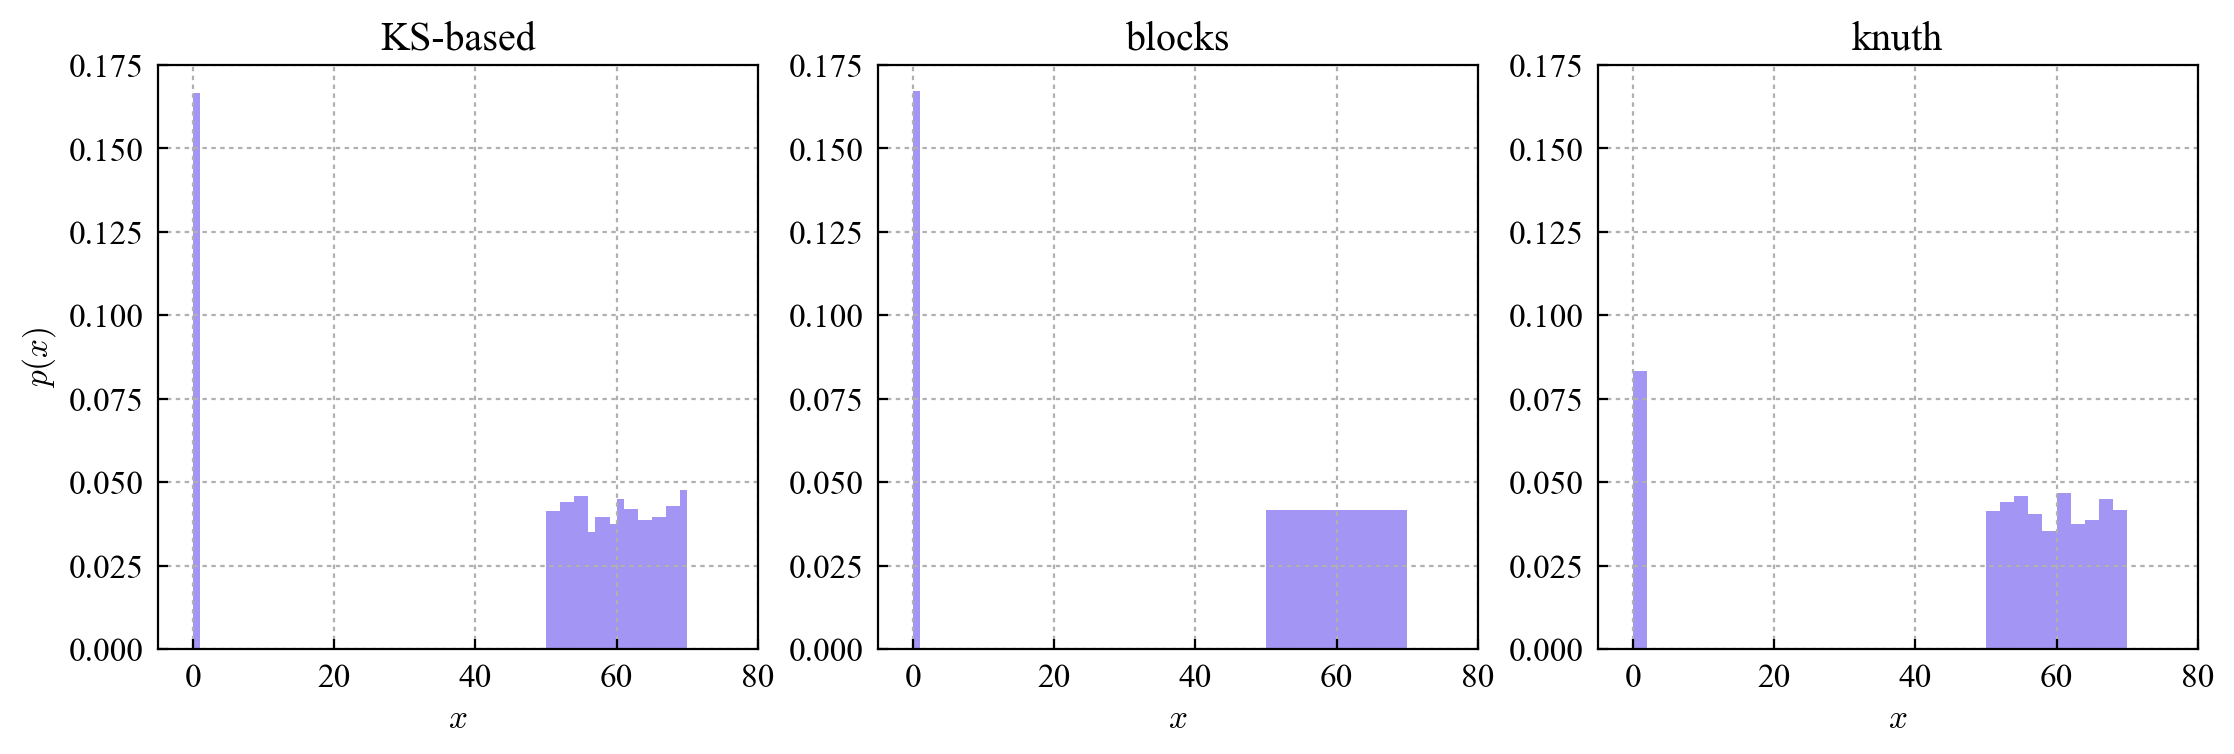

In [40]:
x = np.random.uniform(size=200)
x = np.hstack((x,np.random.uniform(50, 70, size=1000)))
x = np.sort(x)

compare_binning_methods(x, nminb=50, xlims=[-5, 80], ylims=[0., 0.175])

We can control fluctuations among bins with the parameter defining minimum number of samples per bin <tt>nminb</tt>. 

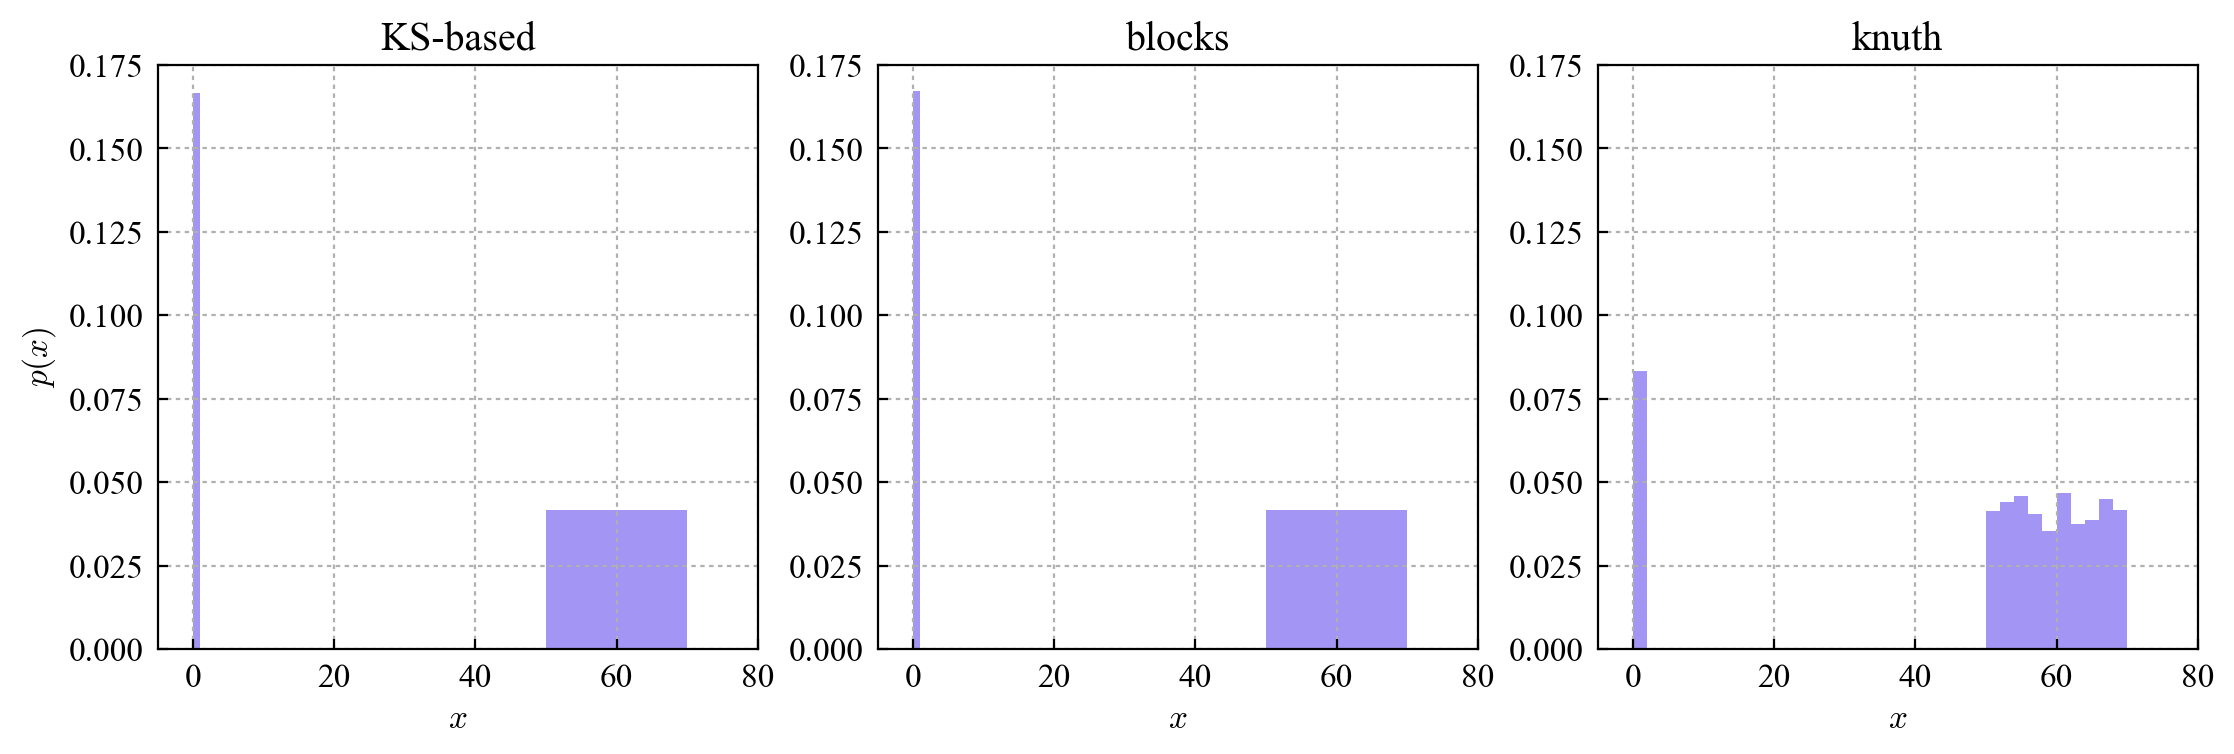

In [41]:
compare_binning_methods(x, nminb=2000, xlims=[-5, 80], ylims=[0., 0.175])

###  Tests using distributions with multiple Gaussian and Cauchy peaks

First functions to produce random samples with specified number of peaks, their means, standard deviationsm and amplitudes

In [42]:
from scipy import stats

def cauchy_peaks(xg, means, scales, amps):
    pxg = np.zeros_like(xg)
    npeaks = means.size
    for i, m in enumerate(means): 
        pxg += amps[i] * stats.cauchy.pdf(xg, m, scales[i])
    return pxg / np.sum(amps)

def gaussian_peaks(xg, gmeans, gstd, gamps):
    pxg = np.zeros_like(xg)
    npeaks = gmeans.size
    for i, m in enumerate(gmeans): 
        pxg += gamps[i] * stats.norm.pdf(xg, m, gstd[i])
    return pxg / np.sum(gamps)

def gaussian(xg, gmeans, gstd, gamps):
    pxg = np.zeros_like(xg)
    pxg = gamps * stats.norm.pdf(xg, gmeans, gstd)
    return pxg / np.sum(gamps)

###  Test with a single Gaussian peak

Test histogramming samples drawn from a Gaussian pdf. 

All methods work reasonably well here. KS-based method allows to control the minimum number of samples per bin, but it works well with very low number here and captures the shape of the distribution well. Knuth method works well, but allows noticeable shot noise in the histogram. Bayesian blocks method suppresses noise completely but "over-smoothes" the peak of the distribution. 

Try changing the number of samples <tt>nr</tt> below and run test multiple times for small values to see how histograms change from one random sample to another. 

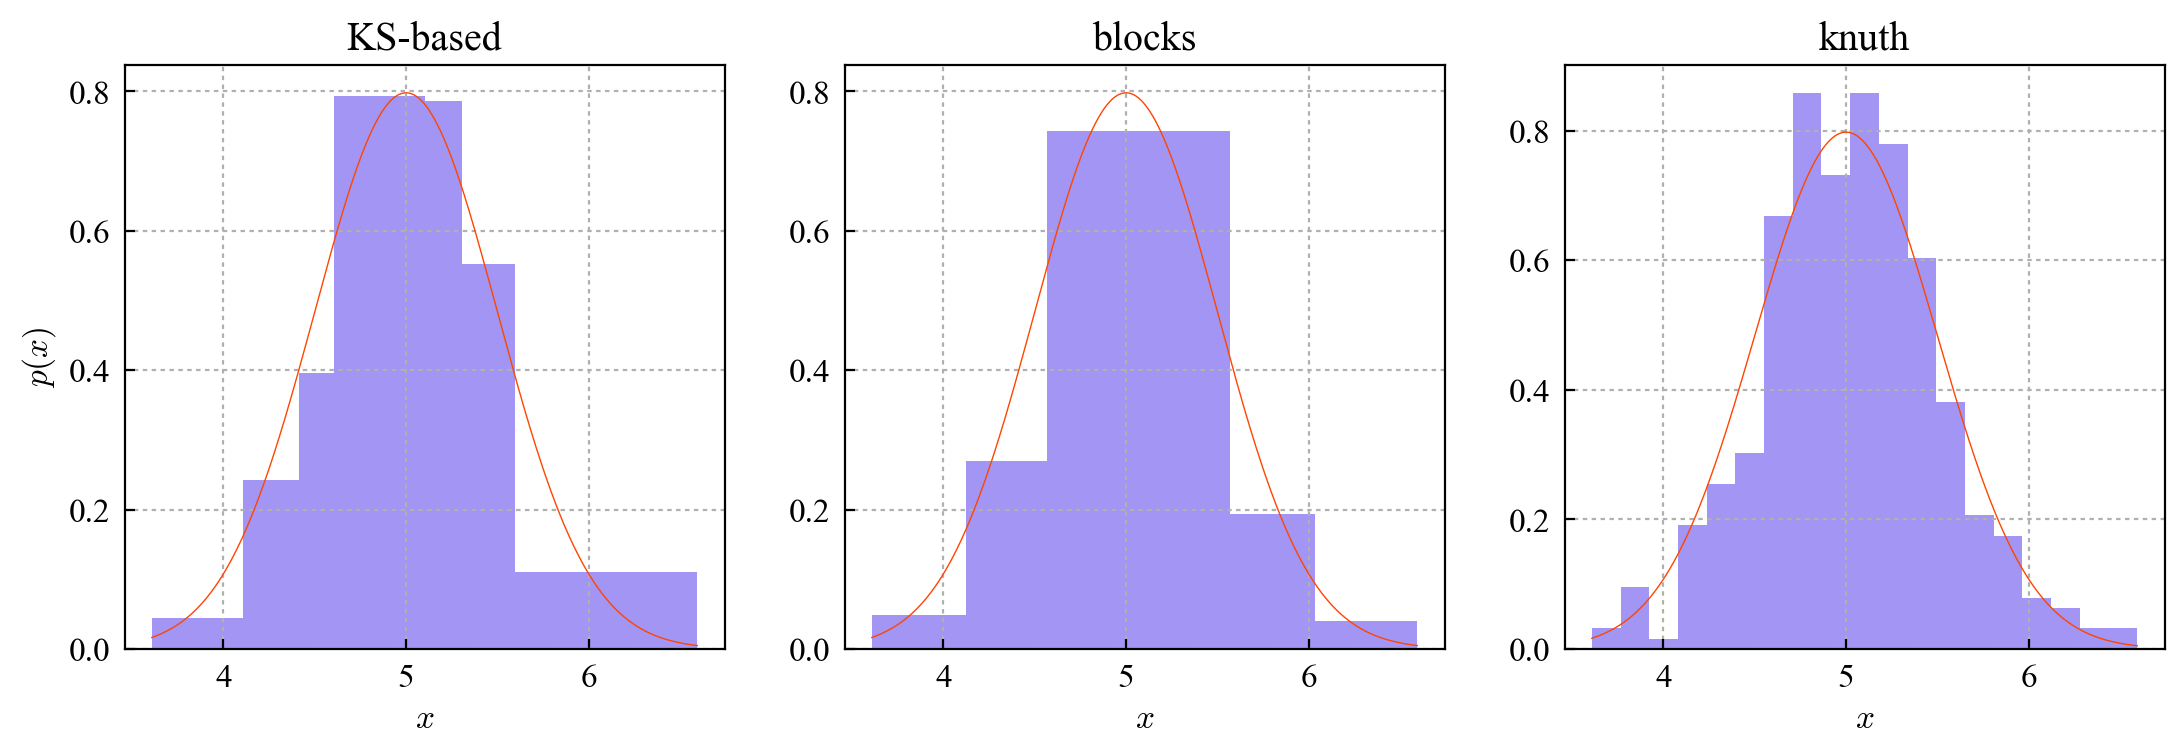

In [43]:
nr = 200
gamps = np.array([2.])
gmeans = np.array([5.])
gstd = np.array([0.5])

x = np.random.normal(loc=gmeans[0], scale=gstd[0], size=2*nr)
x = np.sort(x)

compare_binning_methods(x, nminb=20, func=gaussian, args=[gmeans[0], gstd[0], gamps[0]])

###  Test with two well-separated Gaussian peaks

Next test considers 2 Gaussian peaks well separated from each other. Parameter <tt>nr</tt> here is the number of random samples in the second Gaussian peak. The number of random samples in the first peak is <tt>2nr</tt>, so that the total number of random samples is <tt>3nr</tt>.

This tests for the ability of each method to handle many empty bins between the two peaks. KS-based and Bayesian blocks methods work well, although the BB method generally over-smoothes the peak of the second Gaussian. Knuth method fails here as it uses too few bins for both the left peak (containing 2000 samples) and the right peak. 

The issue with the Knuth method is likely not fundamental, but arises due to empty bins between peaks, which this implementation does not account for. The algorithm can probably be corrected to optimize the number of non-empty bins, not the total number of bins. 

Experiment with the number of random samples <tt>nr</tt> in the second peak and minimum number of samples per bin <tt>nminb</tt> for the adaptive KS binning method to see how histograms are affected. 

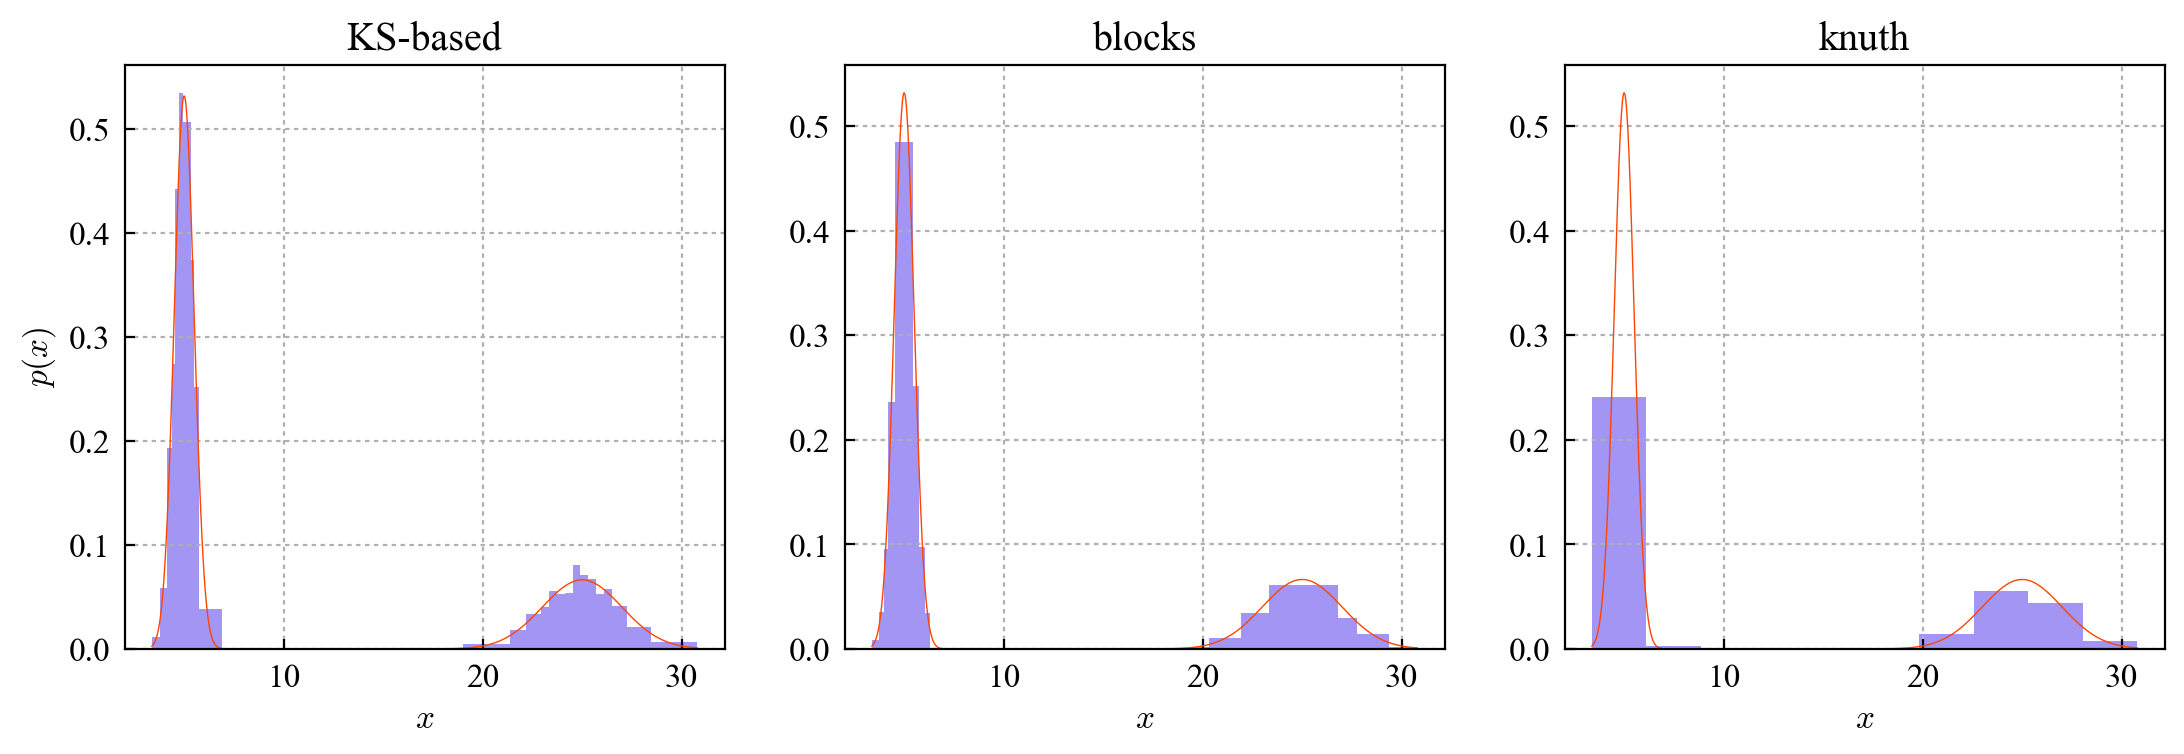

In [44]:
nminb = 50
nr = 1000
gamps = np.array([2., 1.])
gmeans = np.array([5., 25.])
gstd = np.array([0.5, 2])

x = np.random.normal(loc=gmeans[0], scale=gstd[0], size=2*nr)
x = np.hstack((x, np.random.normal(loc=gmeans[1], scale=gstd[1], size=nr)))
x = np.sort(x)

compare_binning_methods(x, nminb=nminb, func=gaussian_peaks, args=[gmeans, gstd, gamps])

Next experiment tests the ability of the binning algorithms to recover real features in the distribution. The samples are generated from 5 Cauchy pdfs which have narrow peaks and shallow tails. Two of the peaks at $x=-5$ and $x=2$ have small amplitude. Red lines show the pdf from which samples were drawn. 

KS-based and Knuth methods recover all of the real peaks without any other spurious features. The use of the constant width bins in the Knuth method, however, does not allow it to "resolve" narrow inner regions of the high-amplitude peaks. 

Bayesian blocks oversmoothes the low-amplitude peaks and they do not clearly appear in its histogram. This indicates that this method can lead to loss of real signal, if the signal has relatively low amplitude.

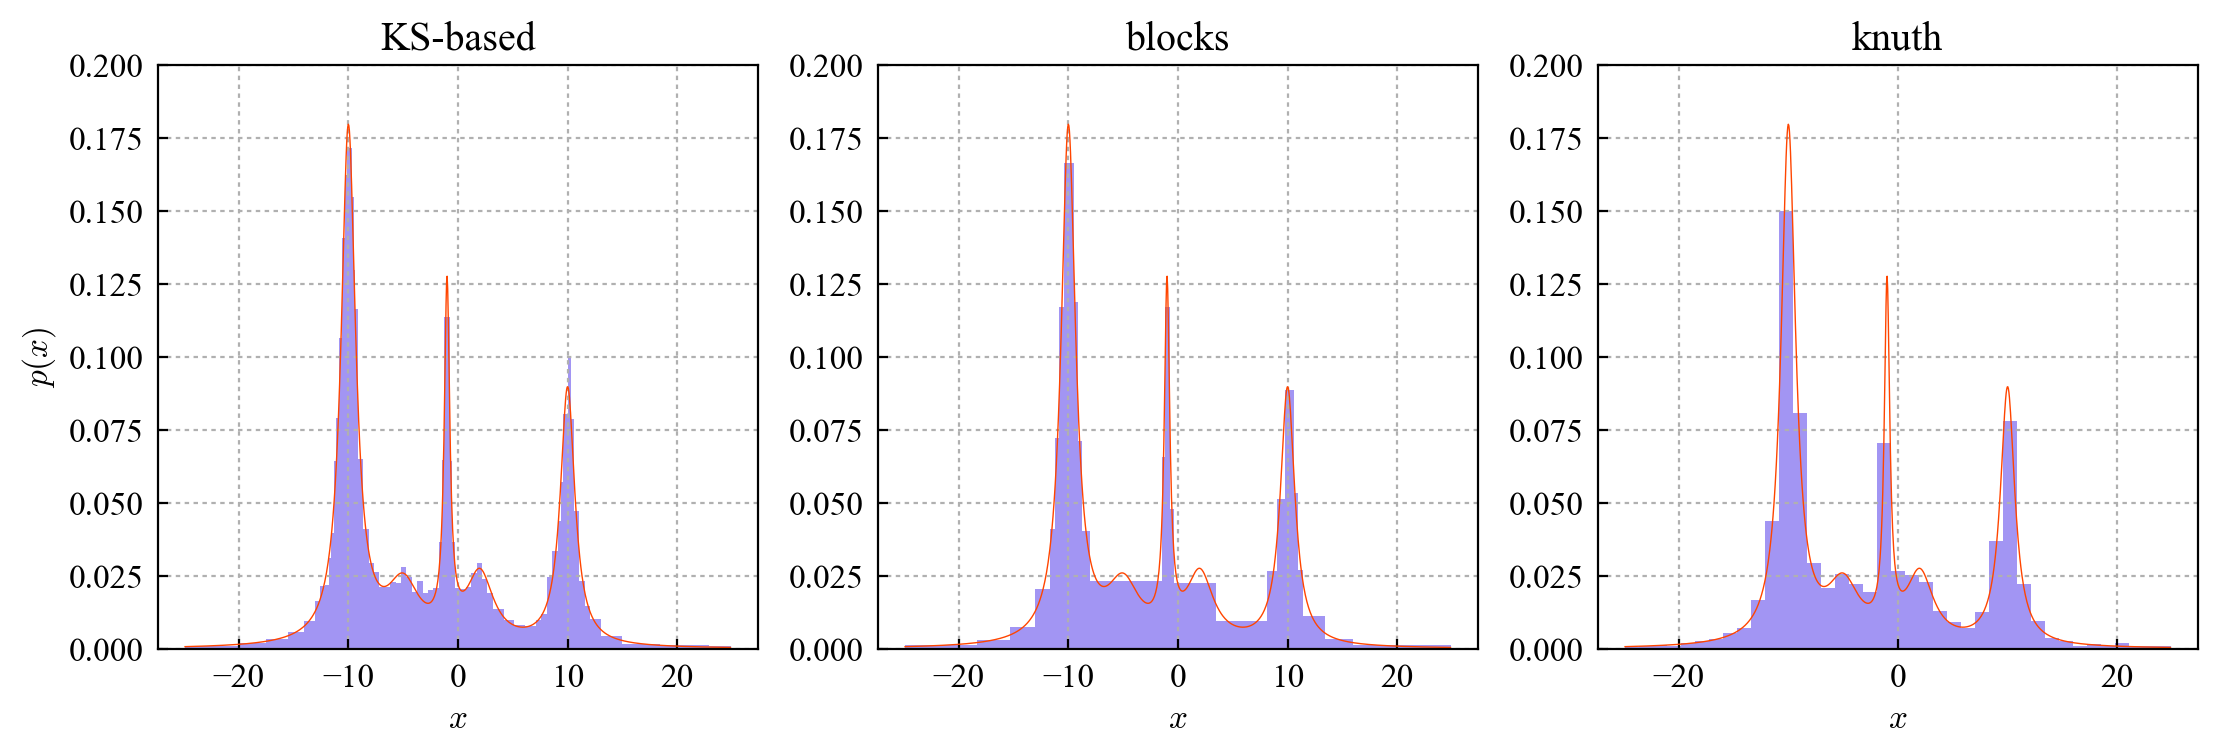

In [45]:
from scipy import stats
nr = 1000
nminb = 50
means = np.array([-10, -5, -1, 2, 10])
scales = np.array([0.8, 1.8, 0.3, 1.5, 0.8])
amps = np.array([4., 1., 1., 1., 2.])

x = np.concatenate([stats.cauchy(-5, 1.8).rvs(nr),
                    stats.cauchy(-10, 0.8).rvs(4*nr),
                    stats.cauchy(-1, 0.3).rvs(nr),
                    stats.cauchy(10, 0.8).rvs(2*nr),
                    stats.cauchy(2, 1.5).rvs(nr)])

x = x[(x>-25.) & (x<25.)]
compare_binning_methods(x, ylims=[0.,0.2], nminb=nminb, func=cauchy_peaks, args=[means, scales, amps])

###  An astronomical test: $g-r$ color distribution of SDSS galaxies

Here we test whether objective binning methods recover the well-known color bimodality of galaxies. Specifically, we will 
use $g-r$ colors of the SDSS galaxies within a narrow range of redshifts and magnitude.  

Galaxies within a narrow redshift range (below $[0.13, 0.14]$) and with $r$ magnitudes in the range $[17.6, 17.77]$ are selected to keep the number of objects reasonably small. Due to the Hubble law, galaxies at approximately the same redshift are at approximately the same distance from us. Selecting galaxies within narrow range of redshifts and magnitudes thus approximately selects galaxies of similar absolute magnitude thereby minimizing the Malmquist bias. 




In [46]:
# define the range of redshifts and r-band magnitudes to select
zmin, zmax = 0.13, 0.14
rmin, rmax = 17.6, 17.77

from astropy.io import fits
hdulist = fits.open('http://astro.uchicago.edu/~andrey/classes/a211/data/sdss_galaxies.fits') 

# data table in the FITS is a dictionary, which we will convert to the numpy dictionary (record)
data = np.asarray(hdulist[1].data)

# select only galaxies within specified redshift and r-magnitude ranges
isel = ((data['r'] > rmin) & (data['r'] < rmax) & (data['z'] > zmin) & (data['z'] < zmax))

# g-r color of all galaxies in the selected subsample
gr = data['g'][isel] - data['r'][isel]

print(f'Selected {gr.size} SDSS galaxies')

Selected 932 SDSS galaxies


The test below shows that the KS-based adaptive binning and Knuth equal bin size methods produce similar results with a clear "green valley" between the blue "cloud" on the left and "red sequence" peak on the right. The Bayesian blocks method however produces binning that looses the blue cloud peak and does not have a green valley. 

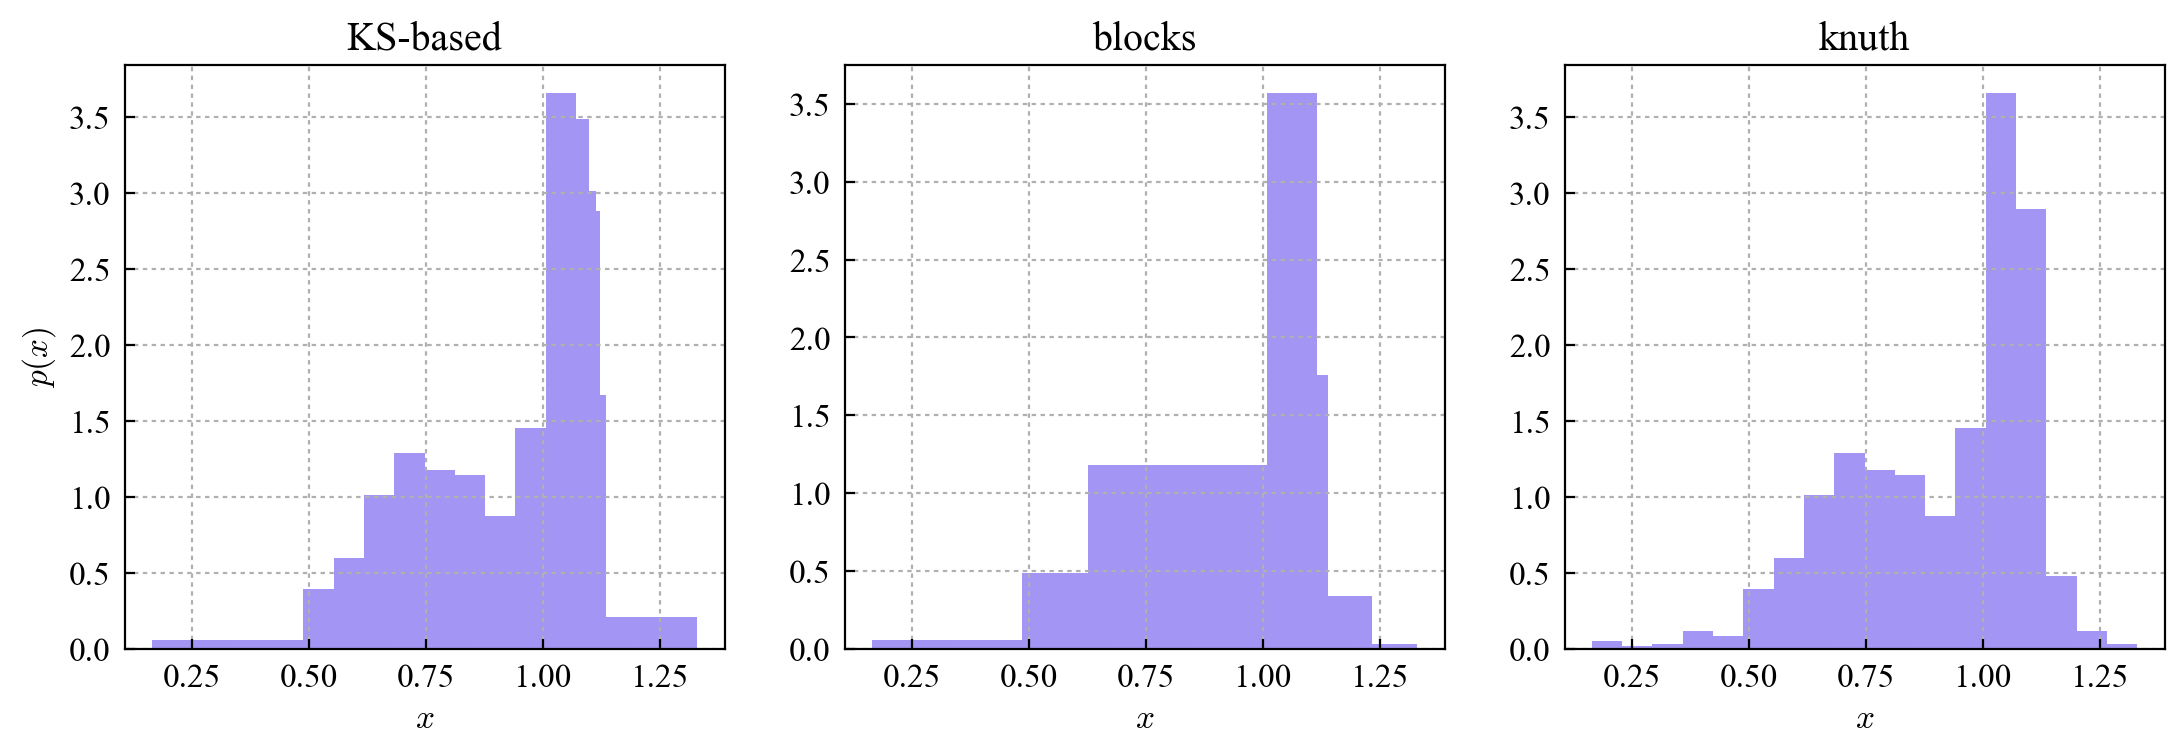

In [47]:
compare_binning_methods(gr, nminb=20)

###  An astronomical cautionary tale: period distribution of exoplanets detected with Kepler

Kepler mission detected many multi-planet systems and analyses of the period ratio distributions among planets in the same system appeared to reveal peaks and gaps that could correspond to orbital resonances ([Lissauer et al. 2011](https://ui.adsabs.harvard.edu/abs/2011ApJS..197....8L/abstract); [Fabrycky et al. 2014](https://ui.adsabs.harvard.edu/abs/2014ApJ...790..146F/abstract)).

Data read below contains 595 period ratios of the Kepler planets in multi-planet systems.

In [48]:
x = np.loadtxt('data/kepler_pr.txt', usecols=(0), unpack=True)

print(f'Read {x.size} planet period ratios')

Read 595 planet period ratios


The plots below show that all binning methods result in similar distributions with a single broad peak with assymetric distribution of the period ratios to the left and right of the peak. 

Bayesian blocks method produces only 5 bins, while KS-based and Knuth produce 12 and 15, respectively. The peak at $x=1.5$ is visible in the KS-based histogram, but gap at $x=2$ is not. 

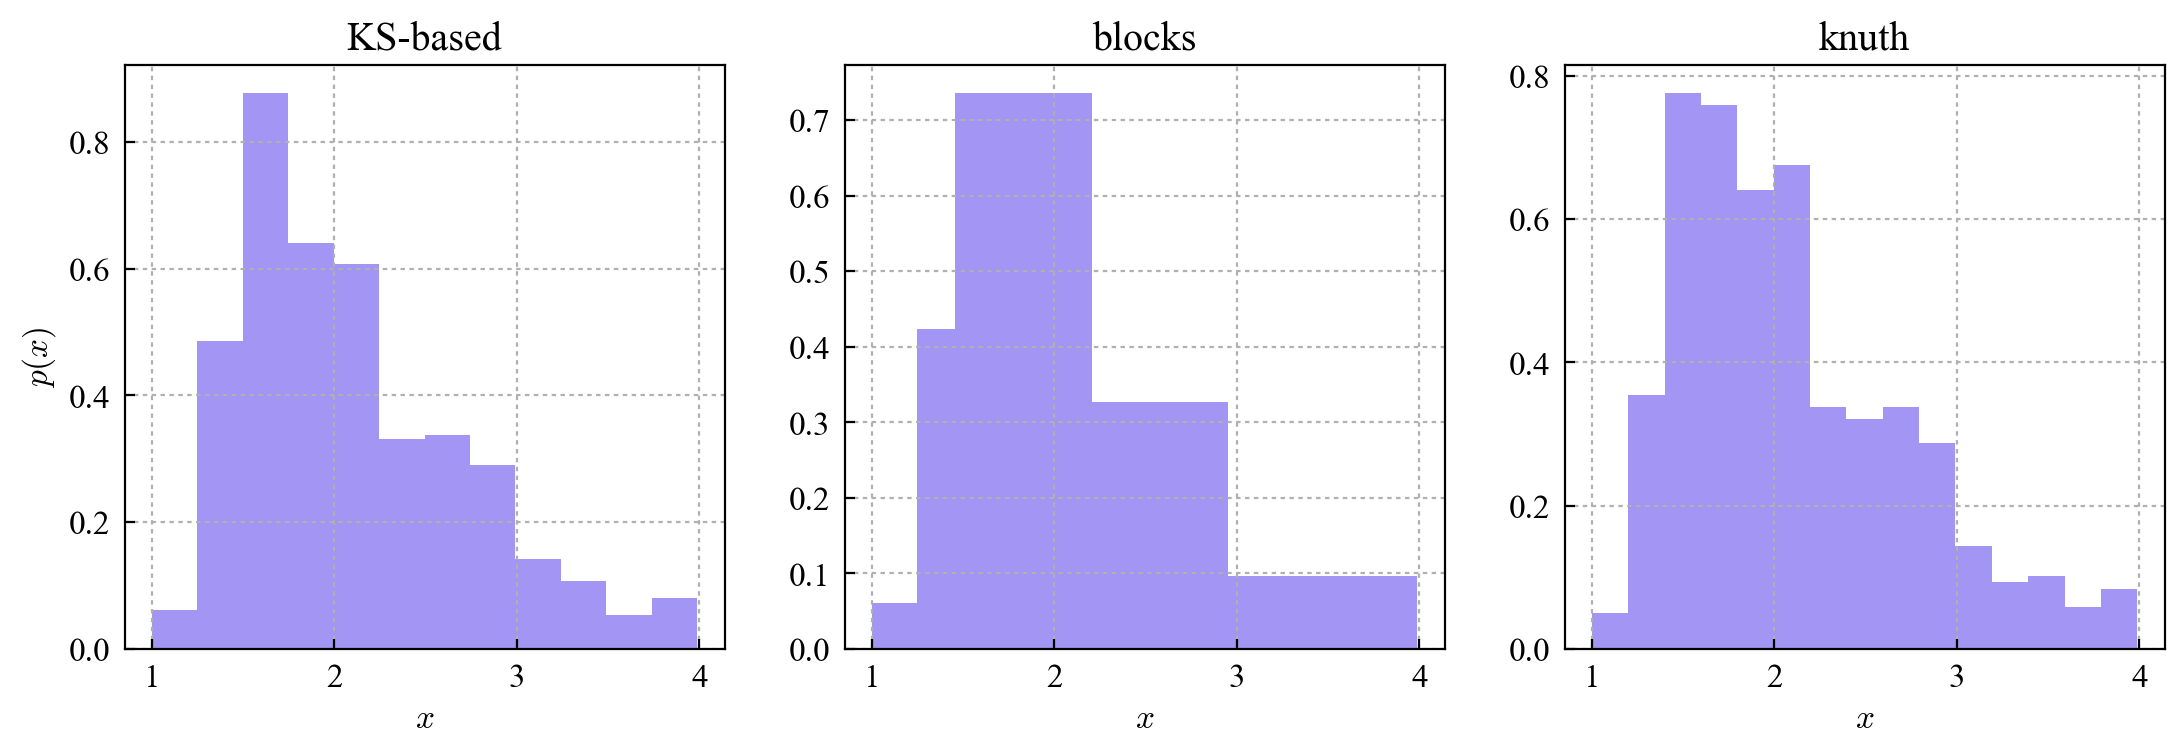

In [49]:
compare_binning_methods(x, nminb=1)

Such binning, however, misses fine structures in the distribution that are considered to be real: in particular, a sharp peak just shy of $x=1.5$ and a narrow gap at $x\approx 2$ (e.g., see [Fabrycky et al. 2014](https://ui.adsabs.harvard.edu/abs/2014ApJ...790..146F/abstract), [Steffen & Hwang 2015](https://ui.adsabs.harvard.edu/abs/2015MNRAS.448.1956S/abstract)). These are visible in the fine-binned histogram below amid the Poisson noise in the surrounding bins. 

One can question significance of these features, but detailed statistical tests using distribution of period ratios around these features seem to indicate that they are significant at $\approx 3\sigma$. 

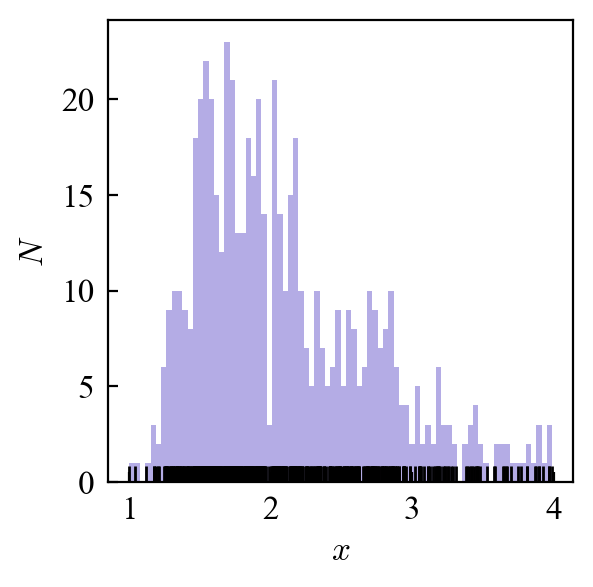

In [50]:
from plotting import plot_histogram

plot_histogram(x, tickmarks=True, bins=80, xlabel='$x$', ylabel='$N$')

This illustrates that the objective binning methods that minimize the global posterior for the entire distribution can well be insensitive to the local features of moderate significance in the regime where number of samples is not too large. Such features can thus be missed if the objective binning is applied blindly.

A different approach which can approximate function adaptively using local information is needed. 

## <font color='darkblue'>Caveats</font>

* KS method, as well as most likelihood based methods, have large errors and may be too conservative in the estimate of the optimal number of bins when number of samples per bin is small. 


* KS test is limited to one dimension and thus cannot be used for function reconstruction in two or more dimensions. Alternatives based on a likelihood can, however, be used. 


* Both KS-based method and Bayesian blocks are quite slow when the number of samples is large (see exercise below). 

## <font color='darkblue'>Exercise</font>

Code below reads X-ray event energies from a Chandra observation of the Galactic Center (from [this AstroPy tutorial](https://learn.astropy.org/tutorials/FITS-tables.html)), subsamples them and then plot energies of the event as a histogram producing X-ray spectrum. 

Plot histograms using different methods and see whether you can see the iron line at $\lambda=1.88$ Angstrom  in each histogram.
You can also compare the histograms to the histogram in the upper panel of left (HEG+1) plot in [Corrales et al. 2020](https://ui.adsabs.harvard.edu/abs/2020ApJ...891...71C/abstract). 

In [135]:
from astropy.io import fits

data = fits.open('http://data.astropy.org/tutorials/FITS-tables/chandra_events.fits', 
                           cache=True )

# subsample the events 
x = 12398. / data[1].data['energy'][::4]  # convert energy in eV to wavelength in Angstroms

# limit events to the range [1.5, 7] Angstrom
x = x[(x>1.5) & (x<7)]
print(x.size)

data.close()

79347


constructed Bayesian Blocks in 65.1 sec


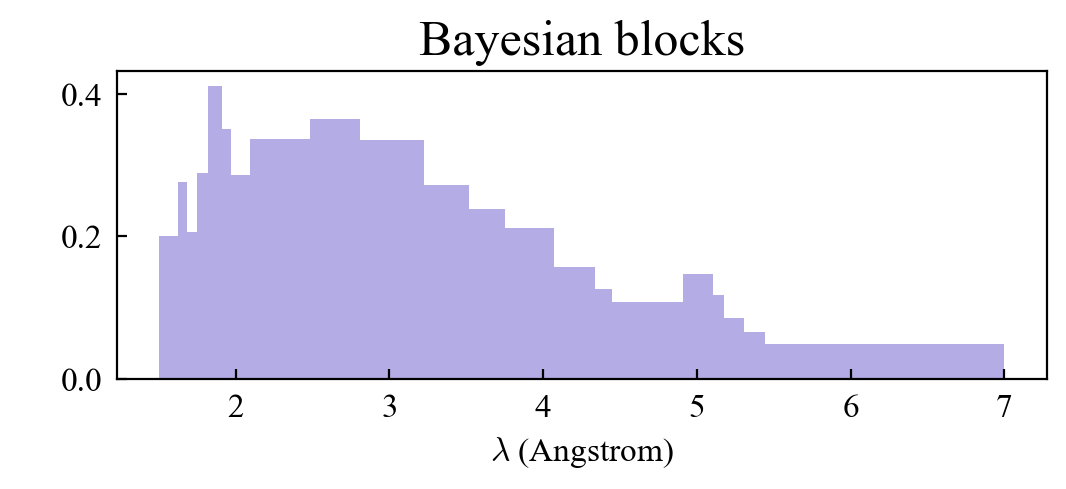

In [145]:
from time import time
from astropy.stats import bayesian_blocks, knuth_bin_width

t0 = time()
block_bins = bayesian_blocks(x)
print(f'constructed Bayesian Blocks in {time()-t0:.3g} sec')

plot_histogram(x, density=True, bins=block_bins, xlabel=r'$\lambda$ (Angstrom)', 
               figsize=(6,2), plot_title='Bayesian blocks')


constructed Knuth equal-size bins in 0.0493 sec


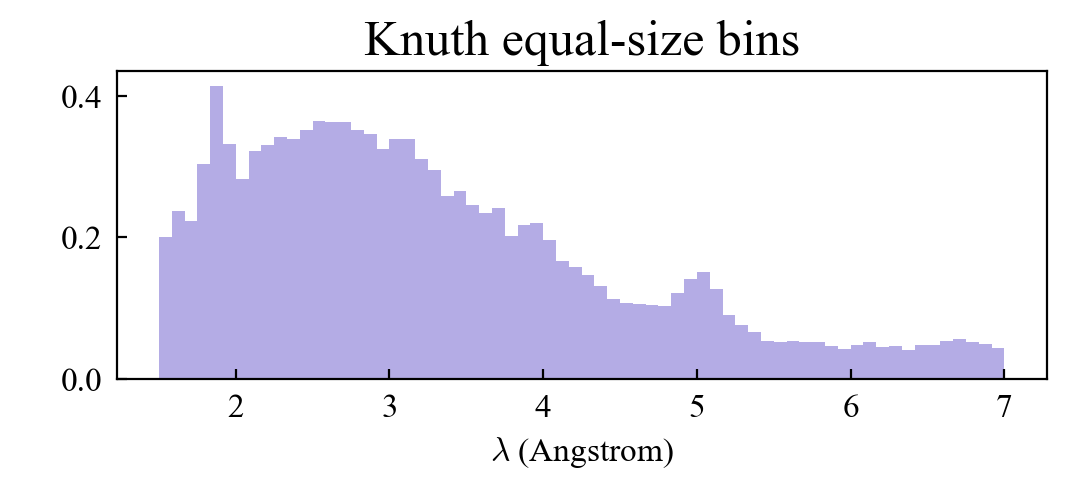

In [141]:
from astropy.stats import knuth_bin_width

t0 = time()
dx, knuth_bins = knuth_bin_width(x, return_bins=True)
print(f'constructed Knuth equal-size bins in {time()-t0:.3g} sec')

plot_histogram(x, bins=knuth_bins, density=True, 
               xlabel=r'$\lambda$ (Angstrom)', figsize=(6,2), plot_title='Knuth equal-size bins')

Compare to using Matplotlib's hist function with <tt>bins='auto'</tt>.

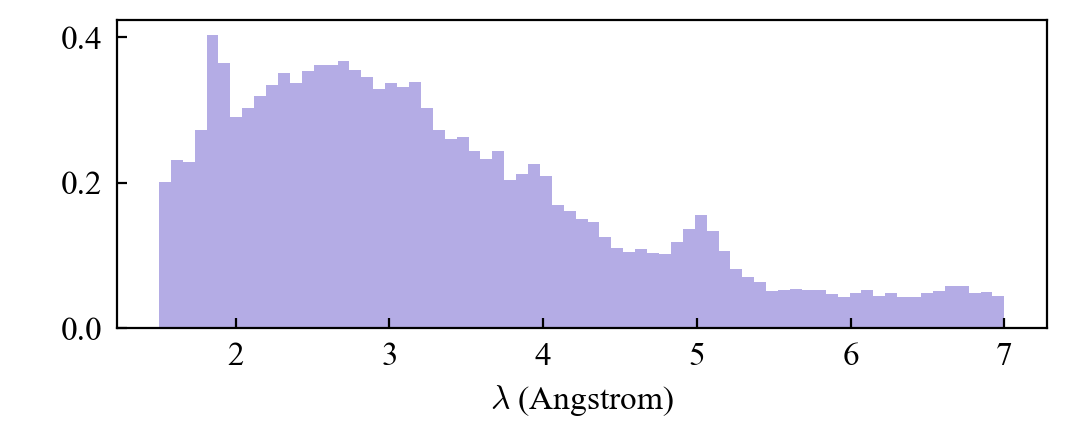

In [142]:
plot_histogram(x, density=True, xlabel=r'$\lambda$ (Angstrom)', figsize=(6,2), bins='auto')

Plot histogram with KS-based equal-sized bins using function <tt>ks_optimal_bin</tt> and adaptive KS-based bins using <tt>ks_adaptive_bins</tt>.